<a href="https://colab.research.google.com/github/mrchapagain/SocialNetworkAnalytics/blob/main/LinkedinAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Process overview

 

1.   **LinkedIn data sources** - retrieving LinkedIn Network data from a "Get a copy of data" CSV export
2.   **Diving into the data** - exploring, cleaning, and aggregating the data with Pandas
1.   **Creating the network** - creating a network graph using NetworkX
2.   **Visualization**- visualizing the network with pyvis
1.   **Improving the output** - cleaning up the network graph with additional filtering






# Loading/Reading in the data

In [ ]:
#!pip install pyjanitor pyvis --quiet
#!pip install pyvis

In [ ]:
# Import the libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import numpy as np

import networkx as nx
from pyvis import network as net
import janitor
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
from datetime import datetime

# Load the data
datalink= "/content/Connections.csv"
df = pd.read_csv(datalink, skiprows=3)
#df = pd.read_csv("../input/dataset/linkedin_data.csv")
df.head()

,First Name,Last Name,Email Address,Company,Position,Connected On
0,Gilbert,Eijkelenboom,NaN,MindSpeaking,Founder,12 Jul 2022
1,Barbara,Koroušić Seljak,NaN,Jožef Stefan Institute,Researcher,06 Jul 2022
2,Sunil,Ghimire,NaN,Fusemachines,Machine Learning Engineer Associate,01 Jul 2022
3,Thomas,Grandjean-Thomsen,NaN,NTT DATA Business Solutions Nordics,"Manager, Business Analytics Team",30 Jun 2022
4,Karolina,Perkman,NaN,Pleo,Student Assistant Compliance (KYC),25 Jun 2022


In [ ]:
new_df = (df
          .clean_names() # remove spacing and capitalization
          .drop(columns=['first_name', 'last_name', 'email_address']) # drop for privacy
          .dropna(subset=['company', 'position']) # drop missing values in company and position
          .to_datetime('connected_on', format='%d %b %Y')
          )
new_df.head()

,company,position,connected_on
0,MindSpeaking,Founder,2022-07-12
1,Jožef Stefan Institute,Researcher,2022-07-06
2,Fusemachines,Machine Learning Engineer Associate,2022-07-01
3,NTT DATA Business Solutions Nordics,"Manager, Business Analytics Team",2022-06-30
4,Pleo,Student Assistant Compliance (KYC),2022-06-25


#Data Exploration
*   New connections over time
*   Top 15 companies my connections work at
*   Top 15 roles my connections work as

#*New connections over time*

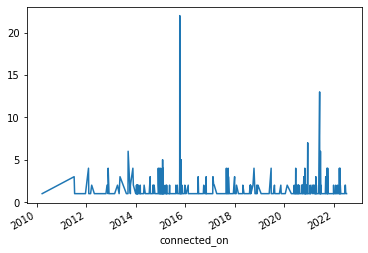

In [ ]:
daily_connections = (new_df
                    .groupby(by=['connected_on']) # group by date
                    .size() # sum up new connections per day
                    .plot() # plot line chart
                      )

#*Top 15 companies my connections work at*

In [ ]:
# Group and sort the data by company 
companies_count = new_df.groupby(by="company").count().reset_index().sort_values(by="position", ascending=False).reset_index(drop=True)# group by company                 
companies_count

# Create a bar plot for the top companies
fig2 = px.bar(companies_count[:10],
              x="company", y="position",
              labels={"position": "Number of count","company": "Organization that my connection belong to"},
              title="Top Companies/Organizations in my Network")
fig2.show()
#new_df['company'].value_counts().head(10).plot(kind="barh").invert_yaxis()

In [ ]:
# Group and sort the data by position 
positions_count = new_df.groupby(by="position").count().reset_index().sort_values(by="company", ascending=False).reset_index(drop=True)
positions_count

# Create a bar plot for the top positions
fig4 = px.bar(positions_count[:10],
              x="position", y="company",
              labels={"position": "Role my connection perform", "company": "No of counts"},
              title="Top Positions in my Network")
fig4.show()



#Aggregate position and connection columns

In [ ]:
# For companies
df_company = new_df['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head()

# For position
df_position = new_df['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head()

,position,count
0,Founder,12
1,Associate Professor,12
2,CEO,11
3,Co-Founder,9
4,Managing Director,9


# Network Analysis

In [ ]:
# Simplenetwork
nt = net.Network(notebook=True)

g = nx.Graph()
g.add_node(0, label = "root") # intialize yourself as central node
g.add_node(1, label = "Company 1", size=10, title="info1")
g.add_node(2, label = "Company 2", size=40, title="info2")
g.add_node(3, label = "Company 3", size=60, title="info3")
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(0, 3)

nt.from_nx(g)
nt.show('nodes.html')
display(HTML('nodes.html'))

In [ ]:
# Reduce size of nodes
# for companies
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=5]
print(df_company_reduced)

# for positions
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=5]
print(df_position_reduced)


(731, 2)
                                             company  count
0                         Copenhagen Business School     11
1  Københavns Universitet - University of Copenhagen     10
2                                 Aalborg University      7
3                                     Scandic Hotels      7
4                                       Novo Nordisk      6
5                                  Aarhus University      5
6                                Roskilde University      5
7                                      Self-employed      5
(680, 2)
                   position  count
0                   Founder     12
1       Associate Professor     12
2                       CEO     11
3                Co-Founder      9
4         Managing Director      9
5                     Owner      7
6                   Manager      6
7             Founder & CEO      6
8              Board Member      6
10      Assistant Professor      5
9   Postdoctoral Researcher      5


In [ ]:
# Creating network for connections

# initialize graph
g = nx.Graph()
g.add_node('root') # intialize myself as central

# use iterrows tp iterate through the data frame
for _, row in df_company_reduced.iterrows():

  # store company name and count
  company = row["company"]
  count = row["count"]

  title = f"<b>{company}</b> – {count}"
  positions = set([x for x in new_df[company == new_df["company"]]["position"]])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f"<ul>{positions}</ul>"
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

In [ ]:
# Creating network for connections

# initialize graph
g = nx.Graph()
g.add_node('root') # intialize myself as central

# use iterrows tp iterate through the data frame
for _, row in df_position_reduced.iterrows():

  # store company name and count
  position = row["position"]
  count = row["count"]

  title = f"<b>{company}</b> – {count}"
  companys = set([x for x in new_df[position == new_df["position"]]["company"]])
  companys = ''.join('<li>{}</li>'.format(x) for x in companys)

  company_list = f"<ul>{companys}</ul>"
  hover_info = title + company_list

  g.add_node(position, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', position, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

#Cleaning up the data

In [ ]:
df = df[df['Company'].notna()].sort_values(by='Company')
df.head()

from difflib import get_close_matches
companies = df['Company'].drop_duplicates()

# cutoff=0.7 is a similarity ranking, and n=10 just takes the top 10 values
similar_companies = {x: get_close_matches(x, companies, n=10, cutoff=0.7)
                     for x in companies}

# We are only interested in the entries that had another match
similar_companies = {x: [name for name in y if name != x]
                     for x, y in similar_companies.items() if len(y) > 1}
similar_companies

{'Aalborg Universitet': ['Ålborg Universitet',
  'Aalborg University',
  'Aarhus University',
  'Nord University'],
 'Aalborg University': ['Aalborg Universitet',
  'Ålborg Universitet',
  'Aarhus University',
  'Nord University'],
 'Aarhus BSS - Aarhus University': ['Aarhus University'],
 'Aarhus University': ['Aalborg University',
  'Nord University',
  'Aarhus BSS - Aarhus University',
  'Aalborg Universitet'],
 'Acceleration Nordic': ['acceleration'],
 'Agilent Technologies': ['Veo Technologies'],
 'CARE Danmark': ['UNICEF Danmark', 'SATS Danmark'],
 'Channel International Education Consultant Pvt. Ltd.': ['Target International Education Pvt. Ltd.'],
 'Compass Group': ['Compass Group Danmark'],
 'Compass Group Danmark': ['Compass Group'],
 'Copenhagen Business Academy': ['Copenhagen Business School'],
 'Copenhagen Business School': ['Copenhagen Business Academy',
  'ESCP Business School'],
 'Cubes International': ['EcoTree International', 'Nutrition International'],
 'DTU - Technic

# Fundamentals of Network Analysis

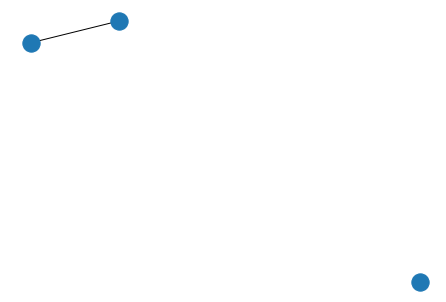

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

G= nx.Graph()
display(G)

# add the nodes in the graph and check the nodes by acessing them
G.add_nodes_from([1,2,3])
G.nodes()

# Lets add the edges in the graph and check the edges by acessing them
G.add_edge(1, 2)
G.edges()

# Lets label the nodes for easily understand them by label and check them
G.nodes[1]['label'] = "Blue"
G.nodes(data= True)

# Display the graph
nx.draw(G)
plt.show()